# Model Predictive Control and Neural Network-based control

The goal of this exercise is to implement two controllers for the `Pendulum-v1` environment of the _Gymnasium_ library: a model-based controller and a model-free, neural network-based controller. Please **read carefully** the [documentation](https://gymnasium.farama.org/environments/classic_control/pendulum/) of environment before starting (focus on the state variables and controls). 

## Part 1: Model Predictive Control

Implement a model-based controller that uses the Model Predictive Control (MPC) theory (see the slides in the _Genetic Algorithm_ set in the repo of the course) to **stabilize the pendulum in its upright position** ($\theta = 0$, $\omega = 0$). Set the **gravity equal to 9.81** using the `g` argument of the `Pendulum-v1` environment. In general, you should follow these steps:

1. Define the _cost_ function associated to the MPC using the **reward** of the environment. For the prediction of the future
   states and rewards associated to a sequence of actions, another _Pendulum_ environment called `env_mpc` (separate from the one
   `main_env` that the controller is interacting with) should be used.
2. Define a `MPC` class compatible with `pygmo` that implements the optimization problem
   that needs to be solved using Model Predictive Control to compute the optimal action
   (the one that minimizes the cost defined at Step 1). Remember to appropriately set
   the bounds for the controls.
3. Implement the `get_best_mpc_action` to actually solve the MPC problem using `pygmo`.
4. Define the function `play_game` to play a "game" using a controller chosen by the
   user among the following: 1) MPC; 2) random; 3) Neural Network (see Part 2). The
   _initial conditions_ for the angle and angular velocity should be randomly set within
   the intervals -20/+20 degrees and -0.1/0.1 rad/s, respectively, using the
   `env.unwrapped.state` variable. For the MPC controller, at each time step an
   optimization problem must be solved using the function defined at Step 3.
   The function should store and return the lists of _observations_ and corresponding
   _controls_ and the _total score_ associated to the game. Each game lasts maximum 200 actions.
5. Play _a few_ games with _random_ initial conditions (angle between -20 and +20 degrees and angular velocity between -0.1 and 0.1 rad/s) and compute the _average total score_. **You should get a total score above -10, at least in some games.** For one game, plot the angle and the angular velocity as a function of time, and the controls in a separate figure.

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch 
import pygmo as pg
from torch import nn, tensor
from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [1]:
def cost_mpc(action_sequence, main_env, env_mpc):
    # set initial state of the environment used for simulating MPC actions equal to the
    # current state in the "real" environment
    env_mpc.unwrapped.state = main_env.unwrapped.state

    total_reward = 0.

    for action in action_sequence:

        _, reward, _, _, _ = env_mpc.step([action])

        total_reward += reward
        
    # we want to minimize the value returned by this function
    return -total_reward

In [3]:
# pygmo problem class for MPC
class MPC():
    def __init__(self, main_env, env_mpc, control_horizon=10):
        self.main_env = main_env
        self.env_mpc = env_mpc
        self.control_horizon = control_horizon

    def fitness(self, action_sequence):
        total_cost = cost_mpc(action_sequence, self.main_env, self.env_mpc)
        return [total_cost]

    def get_bounds(self):
        return ([-2.] * self.control_horizon, [2.] * self.control_horizon)

In [ ]:
# return best action by minimizing MPC cost using genetic algorithm
def get_best_mpc_action(env, env_mpc):
    prob = pg.problem(MPC(env, env_mpc))
    algo = pg.algorithm(pg.sga(gen=20))
    pop = pg.population(prob, size=20)
    pop = algo.evolve(pop)
    best_action = pop.champion_x[0] # take the first action of the best action sequence
    # convert the results into a 1x1 numpy array to be compatible with the step method
    # of the gym environment
    return np.array([best_action])

In [50]:
# Play a game with specified controller
def play_game(controller, nn_model=None):
    env = gym.make('Pendulum-v1', g=9.81)  # Main environment
    env.reset()
    env_mpc = gym.make('Pendulum-v1', g=9.81) # Environment for MPC
    env_mpc.reset()

    # initial conditions
    initial_angle = np.random.uniform(-np.deg2rad(20.), np.deg2rad(20.))
    initial_angular_vel = np.random.uniform(-0.1, 0.1)
    env.unwrapped.state = [initial_angle, initial_angular_vel]

    # set initial x, y and omega (angular velocity)
    previous_obs = np.array([np.cos(initial_angle), np.sin(initial_angle), initial_angular_vel])

    states = []
    controls = []
    total_score = 0

    for _ in range(200):
        if controller == 'MPC':
            # Solve optimization problem to minimize cost function for MPC controller
            action = get_best_mpc_action(env, env_mpc)

        elif controller == 'random':
            action = env.action_space.sample()  # Random action
            
        elif controller == 'NN':
            action = nn_model.predict(previous_obs.reshape(1,-1)).item()
            action = np.array([action])

        states.append(env.unwrapped.state)
        controls.append(action)

        obs, reward, terminated, truncated, _ = env.step(action)
        previous_obs = obs

        # total score after maximum steps 
        total_score += reward

        if terminated or truncated:
            break

    return states, controls, total_score

In [51]:
def average_score_over_games(controller, num_games, nn_model=None):
    total_scores = []

    for _ in range(num_games):
        
        _, _, total_score = play_game(controller, nn_model)
        total_scores.append(total_score)

    average_score = np.mean(total_scores)
    return average_score


In [33]:
# Plotting angle, angular velocity and control 
def plot_game(observations, controls):
    angles = [obs[0] for obs in observations]
    angular_velocities = [obs[1] for obs in observations]

    plt.figure(figsize=(10, 6))


    plt.plot(angles)
    plt.title('Angle vs. Time')
    plt.xlabel('Time steps')
    plt.ylabel('Angle')

    plt.figure(figsize=(10, 6))

    plt.plot(angular_velocities)
    plt.title('Angular Velocity vs. Time')
    plt.xlabel('Time steps')
    plt.ylabel('Angular Velocity')

    plt.figure(figsize=(10, 4))
    plt.plot(controls)
    plt.title('Controls vs. Time')
    plt.xlabel('Time steps')
    plt.ylabel('Controls')

    plt.tight_layout()
    plt.show()

Average Total Score (MPC): -1.0006521488684537
Average Total Score (random): -842.8931328272014


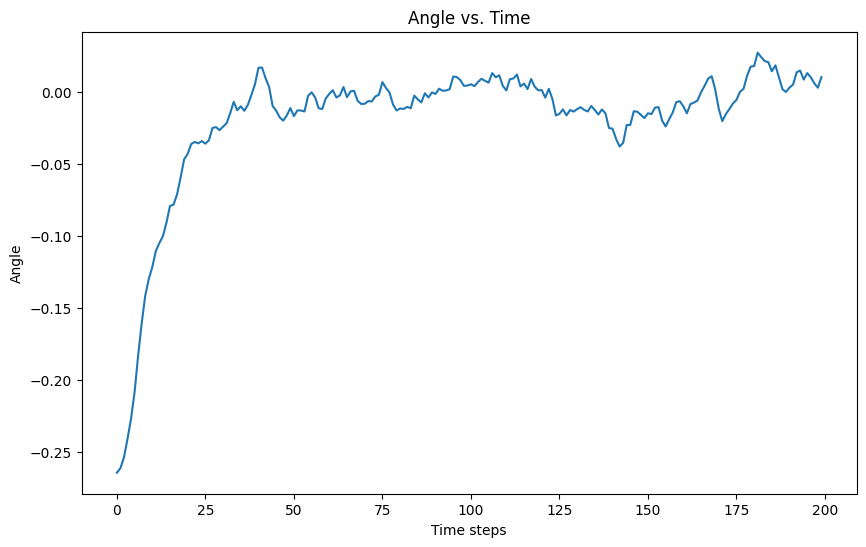

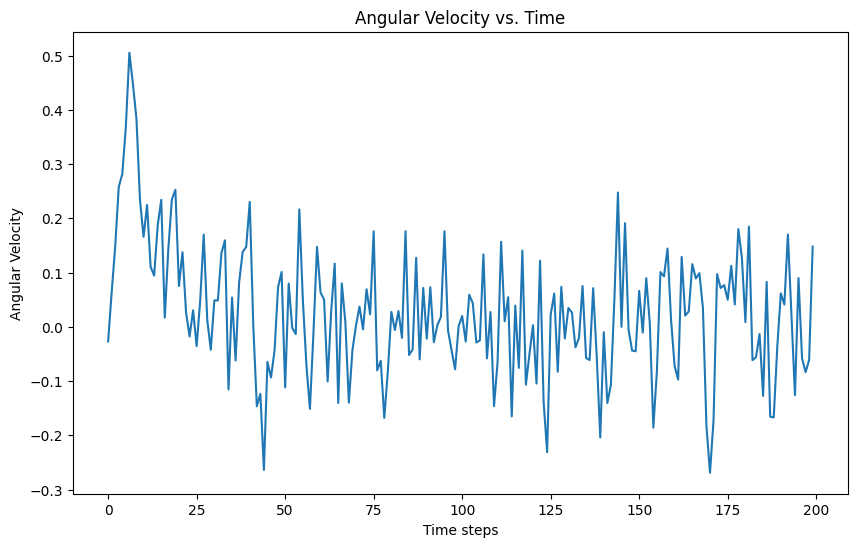

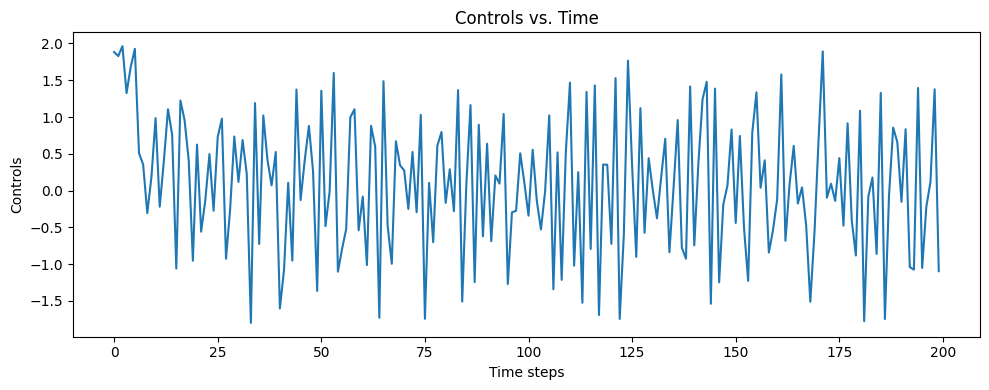

In [34]:
num_games = 5

# Play a few games with random initial conditions and compute the average total score
avg_score = average_score_over_games("MPC", num_games)
print("Average Total Score (MPC):", avg_score)

avg_score = average_score_over_games("random", num_games)
print("Average Total Score (random):", avg_score)
    
# Play one game and plot the results
states, controls, total_score = play_game("MPC")
plot_game(states, controls)


## Part 2: Neural Network controller

In this part, you will train a neural-network based controller based on the optimal control strategy found in Part 1. To this aim you should:
1. Write a function `generate_training_data` to generates a training dataset by playing a certain number of games (suggested minimum
   100) using the MPC controller implemented in Part 1 and providing as random initial conditions
   an angle between -20 and 20 degrees and zero angular velocity. Each step of the game
   corresponds to a sample of the training dataset, where $x$, $y$, $\omega$ are the
   features and the action chosen by the MPC controller is the label. Note: this step may be
   _slow_. Finally, convert the dataset to `torch` tensors ($X$ and $y$) with float32 precision.
2. Create a feedforward neural network implemented in `torch` that takes the current **observation** ($x$, $y$, $\omega$) as an input and returns the **control** to be applied to the system. Make sure that the returned value is "admissible".
3. **Train** and **select** the network (by exploring different _architectures_ and values for the _hyperparameters_).
4. Play 2000 games with the controls given by the "best" network obtained in Step 3. Compute the average total score. **You should get an average score above -5.** Compare the average total score with that of a _random controller_.

In [21]:
def generate_training_data(num_games):
    env = gym.make('Pendulum-v1', g=9.81)  # Main environment
    env_mpc = gym.make('Pendulum-v1', g=9.81) # Environment for MPC

    training_data = []

    for i in range(num_games):
        print("Playing game number ", i + 1)
        env.reset()
        env_mpc.reset()

        initial_angle = np.random.uniform(-np.deg2rad(20.), np.deg2rad(20.))
        initial_angular_vel = 0
        env.unwrapped.state = [initial_angle, initial_angular_vel]
        previous_obs = [np.cos(initial_angle), np.sin(initial_angle), initial_angular_vel]

        total_score = 0.
        game_memory = []
        
        for _ in range (200):
            action = get_best_mpc_action(env, env_mpc)

            # each sample of is a list [[x, y, omega], action]
            game_memory.append([previous_obs, action])
                
            obs, reward, terminated, truncated, _ = env.step([action])
            total_score += reward
            previous_obs = obs
        
            if terminated or truncated:
                break

        # save only the actions of "successful" games
        if total_score >= -0.8:
            for data in game_memory:
                observations = data[0] 
                actions = data[1]
                training_data.append([observations, actions])
        
    return training_data

In [30]:
training_data = generate_training_data(150)

Playing game number  1
Playing game number  2
Playing game number  3
Playing game number  4
Playing game number  5
Playing game number  6
Playing game number  7
Playing game number  8
Playing game number  9
Playing game number  10
Playing game number  11
Playing game number  12
Playing game number  13
Playing game number  14
Playing game number  15
Playing game number  16
Playing game number  17
Playing game number  18
Playing game number  19
Playing game number  20
Playing game number  21
Playing game number  22
Playing game number  23
Playing game number  24
Playing game number  25
Playing game number  26
Playing game number  27
Playing game number  28
Playing game number  29
Playing game number  30
Playing game number  31
Playing game number  32
Playing game number  33
Playing game number  34
Playing game number  35
Playing game number  36
Playing game number  37
Playing game number  38
Playing game number  39
Playing game number  40
Playing game number  41
Playing game number  42
P

In [31]:
X = tensor([i[0] for i in training_data], dtype=torch.float32).reshape(len(training_data), 3)
y = tensor([i[1] for i in training_data], dtype=torch.float32).reshape(len(training_data), 1)

In [43]:
training_data = np.load("data/training_pendulum.npy")
X = tensor(training_data[:,:3], dtype=torch.float32)
y = tensor(training_data[:,3], dtype=torch.float32).reshape(len(training_data),1)

In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_units=50, stack=1):
        super().__init__()
        self.stack = stack
        if self.stack == 1:
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(3, hidden_units),
                nn.ReLU(),
                nn.Linear(hidden_units, hidden_units*2),
                nn.ReLU(),
                nn.Linear(hidden_units*2, hidden_units),
                nn.ReLU(),
                nn.Linear(hidden_units, 1),
                nn.Tanh(),
            )
 
        elif self.stack == 2:
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(3, hidden_units),
                nn.ReLU(),
                nn.Linear(hidden_units, 1),
                nn.Tanh(),
            )

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.linear_relu_stack(x)
        x = 2 * x # range of the torque is [-2,2]
        return x

In [45]:
model = NeuralNetRegressor(module=NeuralNetwork, lr=0.01, batch_size=32, verbose=0,
                           max_epochs=100, module__hidden_units=32, module__stack = 2, iterator_train__shuffle=True)

In [46]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', model),
])

In [47]:
# Hyperparameters for the grid search
params = {
    'model__module__hidden_units': [32, 64],
    'model__module__stack': [1, 2],
    'model__lr': [0.001, 0.01, 0.1],

}
gs = GridSearchCV(pipe, params, cv=3, verbose=3)

gs.fit(X, y)

print(gs.best_score_, gs.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END model__lr=0.001, model__module__hidden_units=32, model__module__stack=1;, score=0.383 total time=  17.3s
[CV 2/3] END model__lr=0.001, model__module__hidden_units=32, model__module__stack=1;, score=0.387 total time=  13.7s
[CV 3/3] END model__lr=0.001, model__module__hidden_units=32, model__module__stack=1;, score=0.368 total time=  13.6s
[CV 1/3] END model__lr=0.001, model__module__hidden_units=32, model__module__stack=2;, score=0.381 total time=  11.0s
[CV 2/3] END model__lr=0.001, model__module__hidden_units=32, model__module__stack=2;, score=0.387 total time=  10.9s
[CV 3/3] END model__lr=0.001, model__module__hidden_units=32, model__module__stack=2;, score=0.368 total time=  10.9s
[CV 1/3] END model__lr=0.001, model__module__hidden_units=64, model__module__stack=1;, score=0.382 total time=  13.8s
[CV 2/3] END model__lr=0.001, model__module__hidden_units=64, model__module__stack=1;, score=0.386 total time=  1

In [48]:
best_model = gs.best_estimator_

In [52]:
# play 2000 games with neural network (NN) and random controllers
avg_score = average_score_over_games("NN", num_games=2000, nn_model=best_model)
print("Average Total Score (NN):", avg_score)

avg_score = average_score_over_games("random", num_games=2000)
print("Average Total Score (random):", avg_score)

Average Total Score (NN): -3.3974668525871317
Average Total Score (random): -896.2323029990222
